In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# df = pd.read_csv("data2/jobs2.csv")
# df = df.loc[(df["keyword"] != "Künstliche_Intelligenz") & (df["keyword"] != "Artificial_Intelligence")]
# df.drop("keyword", axis=1, inplace=True)
# df.drop_duplicates(inplace=True)
# df.shape

In [81]:
# df = pd.read_csv("data2/jobs2.csv")
# df.drop("keyword", axis=1, inplace=True)
# df.drop_duplicates(inplace=True)
# df.shape

In [4]:
df = pd.read_csv("data2/jobs_updated.csv")
df.shape

(3761, 14)

In [5]:
df.head()

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,salary,company_size,contract_type,work_type
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,NaN,2501-5000,Feste Anstellung,"Vollzeit, Home Office möglich"
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Berlin,Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,51.000 - 68.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,"Dortmund, Düsseldorf, Aachen",Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,51.000 - 74.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,"Düsseldorf, Palma de Mallorca",We create the future of B2B commerce by giving...,IT & Internet,NaN,NaN,NaN,2022-06-01,74.000 - 98.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
4,https://www.stepstone.de/stellenangebote--Werk...,CHECK24,Werkstudent BI und Data Science Manager (m/w/d...,München,"Bist Du bereit, etwas zu bewegen und neue, spa...",Finanzdienstleister|Versicherungen,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-06-01,NaN,2501-5000,"Studentenjobs, Werkstudent",Teilzeit


In [6]:
with pd.option_context("display.max_colwidth", None):
    print(df.loc[21, "link"])

https://www.stepstone.de/stellenangebote--Senior-DevOps-Engineer-Data-Science-Berlin-Schoeneberg-NEW-YORKER--8236735-inline.html


In [7]:
df.isnull().sum()

link                0
company             0
title               0
location            0
content             0
industry          637
rating           1137
num_ratings      1137
company_link      751
release_date        0
salary           1643
company_size      974
contract_type       0
work_type           0
dtype: int64

Vorgehen:
- für die Gehaltprognose sind nur Vollzeit Jobs mit Festanstellung relevant
    - zwei Dataframes erzeugen: gefiltert/ungefiltert
    - auf dem gefilterten DF werden alle Gehaltsstatistiken ausgewertet
    - anschließend werden die Transformationen auf dem ungefilterten DF ausgeführt und auf Edge Cases untersucht
- Gehalt umwandeln
- Jobtitel klassifizieren
- Standorte säubern ==> zwei Dataframes erzeugen
    - Long-Format ==> Visualisierung der Standorte (Jobs können mehrfach enthalten sein)
    - Wide-Format ==> alle weiteren Analysen (jeder Job darf nur einmal enthalten sein)
        - Data Cleaning im Long-Format durchführen und anschließend wieder zurück transformieren
        - zusätzliche Features erzeugen (z.B. Anzahl der Standorte, Hauptstandort, binäre Features für Großstädte)
- Branchen umwandeln
    - OHE zum späteren Filtern nutzen
    - zusätzliches Feature mit erster Branche behalten 
- Bewertungen / Anzahl der Bewertungen / Unternehmensgröße ist korrektes Format umwandeln
- Text Mining auf den Inhalten der Jobbeschreibung durchführen

# Evaluate Contract Type

In [8]:
df["contract_type"].value_counts()

Feste Anstellung                                                            3218
Befristeter Vertrag                                                          151
Studentenjobs, Werkstudent                                                   117
Praktikum                                                                     95
Berufseinstieg/Trainee                                                        47
Ausbildung, Studium                                                           44
Praktikum, Studentenjobs, Werkstudent                                         28
Bachelor-/Master-/Diplom-Arbeiten                                             23
Promotion/Habilitation                                                        14
Feste Anstellung, Berufseinstieg/Trainee                                       9
Bachelor-/Master-/Diplom-Arbeiten, Praktikum                                   5
Arbeitnehmerüberlassung                                                        4
Feste Anstellung, Ausbildung

In [9]:
# Festanstellung + Trainee
# Praktikum + Abschlussarbeit + (Studentenjob)
# Arbeitnehmerüberlassung (Leiharbeit) einmalig mit Festanstellung ==> Kategorie entfernen
# einmal Duales Studium (Festanstellung + Studium)
# Freie Mitarbeit bedeutet Festanstellung

In [10]:
contracts = df["contract_type"].str.replace(", ", ",").str.get_dummies(",")
contracts.sum().sort_values(ascending=False)

Feste Anstellung                     3230
Befristeter Vertrag                   151
Studentenjobs                         148
Werkstudent                           148
Praktikum                             129
Berufseinstieg/Trainee                 56
Ausbildung                             45
Studium                                45
Bachelor-/Master-/Diplom-Arbeiten      30
Promotion/Habilitation                 14
Arbeitnehmerüberlassung                 5
Freie Mitarbeit/Projektmitarbeit        1
dtype: int64

In [11]:
# später mit str.contains("a|b|c") filtern

In [12]:
def convert_contract(x):
    x["contract_type"] = x["contract_type"].str.replace(", Werkstudent", "/Werkstudent")
    x["contract_type"] = x["contract_type"].str.replace(", Studium", "/Studium")
    x["contract_type"] = x["contract_type"].str.replace("Freie Mitarbeit/Projektmitarbeit", "Feste Anstellung")
    x["contract_type"] = x["contract_type"].str.replace("Bachelor-/Master-/Diplom-Arbeiten", "Abschlussarbeit")
    return x

df = convert_contract(df)
contracts = df["contract_type"].str.replace(", ", ",").str.get_dummies(",")
contracts.sum().sort_values(ascending=False)

Feste Anstellung             3231
Befristeter Vertrag           151
Studentenjobs/Werkstudent     148
Praktikum                     129
Berufseinstieg/Trainee         56
Ausbildung/Studium             45
Abschlussarbeit                30
Promotion/Habilitation         14
Arbeitnehmerüberlassung         5
dtype: int64

In [13]:
df = pd.concat([df, contracts], axis=1)
df.shape

(3761, 23)

In [14]:
# wieviele Gehaltsangaben existieren für Jobs ohne Festanstellung?
# Studentenjobs und Werkstudent sind gleich
# Ausbildung und Studium sind gleich
# die einzelnen Kategorien sind nicht exklusiv

In [15]:
df.loc[df["Feste Anstellung"]==0, "salary"].isnull().value_counts()

True     524
False      6
Name: salary, dtype: int64

In [16]:
df.loc[(contracts["Feste Anstellung"] == 1), "contract_type"].value_counts()

Feste Anstellung                               3219
Feste Anstellung, Berufseinstieg/Trainee          9
Feste Anstellung, Ausbildung/Studium              1
Arbeitnehmerüberlassung, Feste Anstellung         1
Feste Anstellung, Studentenjobs/Werkstudent       1
Name: contract_type, dtype: int64

In [17]:
# für Jobs ohne contract_type Festanstellung existieren lediglich 6 Gehaltsprognosen für 530 Jobs
# von daher macht es wenig Sinn in das spätere Modell auch andere Stelle außer mit Festanstellung miteinzubeziehen

In [18]:
df.loc[(df["Feste Anstellung"] == 1) & (df["salary"].notnull()), "contract_type"].value_counts()

Feste Anstellung                               2104
Feste Anstellung, Berufseinstieg/Trainee          6
Arbeitnehmerüberlassung, Feste Anstellung         1
Feste Anstellung, Studentenjobs/Werkstudent       1
Name: contract_type, dtype: int64

In [19]:
df_model = df.loc[df["Feste Anstellung"] == 1]
df_model.shape

(3231, 23)

# Evaluate Work Type

In [20]:
df["work_type"].value_counts()

Vollzeit                                   2084
Vollzeit, Home Office möglich              1150
Vollzeit, Teilzeit, Home Office möglich     214
Vollzeit, Teilzeit                          174
Teilzeit                                     99
Teilzeit, Home Office möglich                40
Name: work_type, dtype: int64

In [21]:
df.loc[df["Feste Anstellung"] == 0, "work_type"].value_counts()

Vollzeit                                   220
Teilzeit                                    89
Vollzeit, Home Office möglich               72
Vollzeit, Teilzeit                          68
Vollzeit, Teilzeit, Home Office möglich     44
Teilzeit, Home Office möglich               37
Name: work_type, dtype: int64

In [22]:
# scheinbar keine Veränderung der Verteilung in Abhängigkeit vom Contract Type

In [23]:
df.groupby("work_type")["salary"].apply(lambda x: x.notnull().sum()).sort_values(ascending=False)

work_type
Vollzeit                                   1162
Vollzeit, Home Office möglich               761
Vollzeit, Teilzeit, Home Office möglich     122
Vollzeit, Teilzeit                           71
Teilzeit                                      2
Teilzeit, Home Office möglich                 0
Name: salary, dtype: int64

In [24]:
# für Teilzeit Jobs existieren kaum Gehaltsprognosen ==> nicht in das Modell mit einbeziehen
# wirkt sich Homeoffice auf Gehalt aus?
# ist Homeoffice abhängig vom Jobtyp, Unternehmen, Erfahrungslevel?

In [25]:
work_types = df["work_type"].str.replace(", ", ",").str.get_dummies(",")
work_types

,Home Office möglich,Teilzeit,Vollzeit
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,0,1,0
...,...,...,...
3756,0,0,1
3757,1,0,1
3758,0,0,1
3759,0,0,1


In [26]:
df = pd.concat([df, work_types], axis=1)
df.shape

(3761, 26)

In [27]:
df.groupby(df["Teilzeit"])["salary"].apply(lambda x: x.notnull().sum() / len(x)).sort_values(ascending=False)

Teilzeit
0    0.594620
1    0.370019
Name: salary, dtype: float64

In [28]:
df.groupby(df["Home Office möglich"])["salary"].apply(lambda x: x.notnull().sum() / len(x)).sort_values(ascending=False)

Home Office möglich
1    0.628917
0    0.523971
Name: salary, dtype: float64

In [29]:
df.loc[df["Vollzeit"]==0, "work_type"].value_counts()

Teilzeit                         99
Teilzeit, Home Office möglich    40
Name: work_type, dtype: int64

In [30]:
df_model = df.loc[(df["Feste Anstellung"] == 1) & (df["Vollzeit"] == 1)]
df_model.shape

(3218, 26)

# Evaluate Salary

In [31]:
def convert_salary(x):
    x["min_salary"] = x["salary"].str.split(" ").str[0].str.replace(".", "", regex=False).astype("float")
    x["max_salary"] = x["salary"].str.split(" ").str[2].str.replace(".", "", regex=False).astype("float")
    x["average_salary"] = (x["min_salary"] + x["max_salary"]) / 2
    x.drop("salary", axis=1, inplace=True)
    return x

df = convert_salary(df)

<AxesSubplot:xlabel='average_salary'>

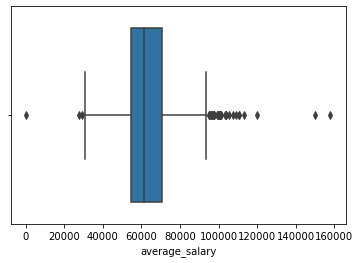

In [32]:
sns.boxplot(x=df["average_salary"])

In [33]:
# Ausreißer bei 0 muss auf jeden Fall entfernt werden
# zum Trainieren des Modelles kann es sinnvoll sein, andere Ausreißer ebenfalls zu entfernen (könnten Ergebnisse verzerren)

In [34]:
df.loc[df["average_salary"]<25000, ["min_salary", "max_salary", "average_salary"]] = np.nan

In [35]:
df.loc[df["average_salary"]>120000]

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,...,Feste Anstellung,Praktikum,Promotion/Habilitation,Studentenjobs/Werkstudent,Home Office möglich,Teilzeit,Vollzeit,min_salary,max_salary,average_salary
1060,https://www.stepstone.de/stellenangebote--VP-G...,Evotec SE,VP Global Head Cellular Sciences (f/m/d),Hamburg,Evotec is a life science company with a uniqu...,Pharmaindustrie,3.6,5 Bewertungen,NaN,2022-06-03,...,1,0,0,0,0,0,1,142000.0,174000.0,158000.0
3124,https://www.stepstone.de/stellenangebote--Supp...,Elmar Hertzog und Partner Management Consultan...,Supply Chain Strategy Director (f/m/d),Berlin,Hertzog & Partner was founded in 1978 and sinc...,NaN,NaN,NaN,NaN,2022-06-01,...,1,0,0,0,0,0,1,120000.0,180000.0,150000.0


In [36]:
# gehört eigentlich zur EDA

In [37]:
titles_grouped = df.groupby("title_cat")["average_salary"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)
with pd.option_context('display.precision', 0):
    print(titles_grouped)

KeyError: 'title_cat'

<AxesSubplot:xlabel='title_cat', ylabel='mean'>

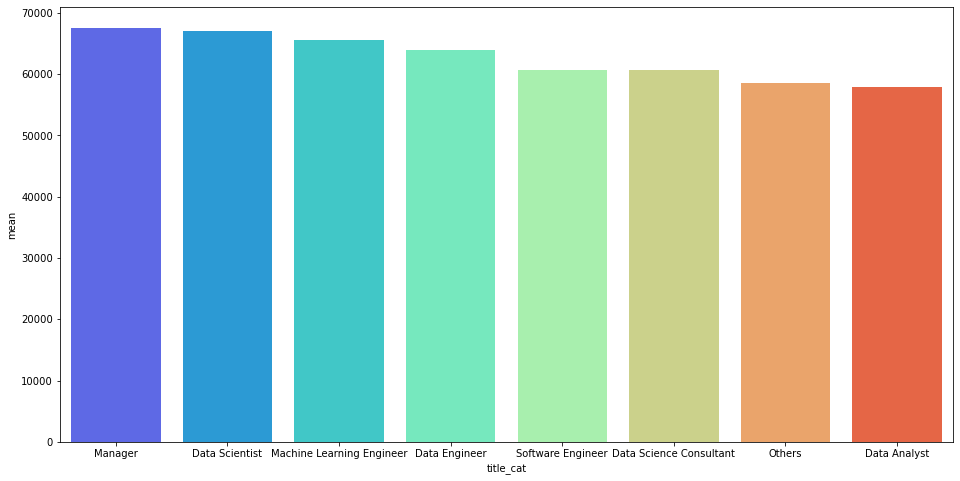

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x=titles_grouped.index, y=titles_grouped["mean"], palette="rainbow")

<AxesSubplot:xlabel='title_cat', ylabel='average_salary'>

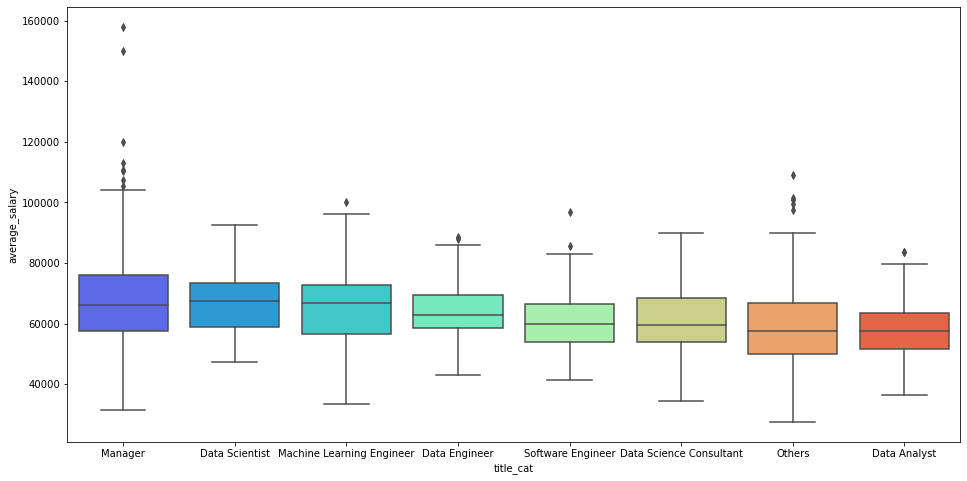

In [41]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df, x="title_cat", y="average_salary", order=titles_grouped.index, palette="rainbow")

In [42]:
# Verteilung der Gehälter entspricht dem, was man erwarten kann
# hohes Durchschnittsgehalt bei Data Scientists kann daran liegen, dass Research Scientist hier mit eingegliedert wurde
# Manager und Other unterliegen der größten Varianz, da hier eine Menge unterschiedlicher Bezeichnungen einfließen
# eventuell macht es Sinn für die Modellbildung die sehr hohen Managergehälter beim Training auszuschließen

<AxesSubplot:xlabel='title_cat', ylabel='average_salary'>

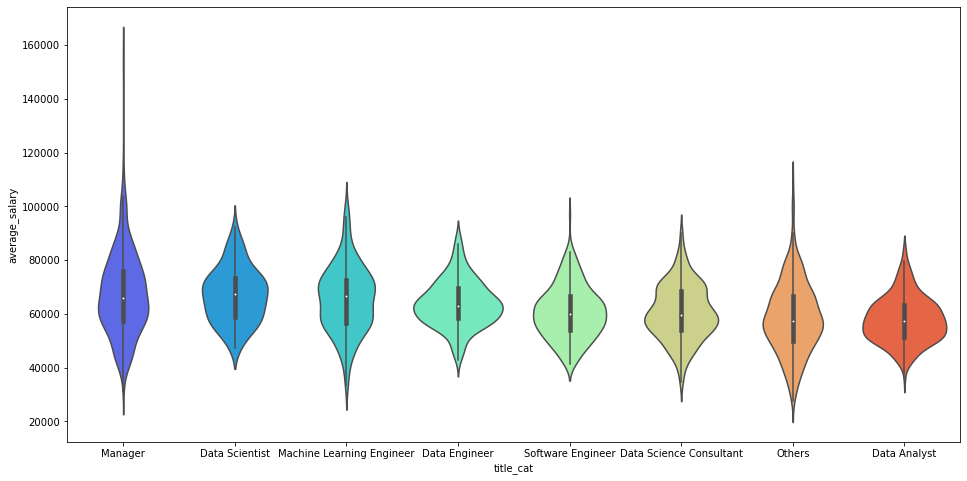

In [45]:
plt.figure(figsize=(16,8))
sns.violinplot(data=df, x="title_cat", y="average_salary", order=titles_grouped.index, palette="rainbow")

In [46]:
titles_grouped = df.groupby("experience")["average_salary"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)
with pd.option_context('display.precision', 0):
    print(titles_grouped)

             mean    std  count
experience                     
Senior      67566  11044    270
Manager     67211  15096    527
Mid-Level   60310  11087   1244
Junior      50197   6200     74


In [47]:
df.loc[(df["title_cat"] == "Manager") & (df["average_salary"]<40000)]

,link,company,title,location,contract_type,work_type,content,industry,rating,num_ratings,company_link,release_date,company_size,title_cat,experience,min_salary,max_salary,average_salary
5882,https://www.stepstone.de/stellenangebote--Sach...,SWT-AöR,Sachbearbeiter:in Prozessmanagement (m/w/d),Trier,Feste Anstellung,Vollzeit,Für unsere Abteilung „Abrechnung/Marktprozesse...,NaN,NaN,NaN,NaN,2022-05-31,NaN,Manager,Manager,35000.0,44000.0,39500.0
6553,https://www.stepstone.de/stellenangebote--Cont...,STRATO Customer Service GmbH,Content Manager (m/w/d),Berlin,Feste Anstellung,Vollzeit,Einleitung Die STRATO Customer Service GmbH er...,NaN,NaN,NaN,NaN,2022-06-02,NaN,Manager,Manager,26000.0,41000.0,33500.0
7653,https://www.stepstone.de/stellenangebote--Supp...,Robert Half,Support Specialist / Teamassistenz (w/m/d) Bew...,Deutschland,Feste Anstellung,Vollzeit,Support Specialist / Teamassistenz (w/m/d) Bew...,Personaldienstleistungen,3.9,728 Bewertungen,https://www.stepstone.de/cmp/de/Robert-Half-38...,2022-05-31,1001-2500,Manager,Manager,29000.0,34000.0,31500.0
7654,https://www.stepstone.de/stellenangebote--Supp...,Robert Half,Support Specialist / Teamassistenz (w/m/d) Ver...,Hamburg,Feste Anstellung,Vollzeit,Support Specialist / Teamassistenz (w/m/d) Ver...,Personaldienstleistungen,3.9,728 Bewertungen,https://www.stepstone.de/cmp/de/Robert-Half-38...,2022-05-31,1001-2500,Manager,Manager,33000.0,37000.0,35000.0
7686,https://www.stepstone.de/stellenangebote--Assi...,Condo Group GmbH,Assistenz (m/w/d) der Standortleitung / Vertri...,Köln,Feste Anstellung,Vollzeit,CONDO ist ein voll-digitalisierter Real Estate...,NaN,NaN,NaN,NaN,2022-05-20,NaN,Manager,Manager,32000.0,47000.0,39500.0


In [48]:
# dass Manager im Schnitt nicht noch weiter vorne liegen, liegt daran, dass bei der obigen Zuordnung auch Assitenten des Managers
# nicht von diesem zu unterscheiden waren ==> treiben den Schnitt nach unten
# eine genauere Einteilung würde eine viele feinere Analyse erfordern, die sehr viel Zeit in Anspruch nehmen würde

# Evaluate Job Title

In [38]:
df["title"].value_counts()

Data Engineer (m/w/d)                                      22
Data Scientist (m/w/d)                                     19
Data Analyst (m/w/d)                                       17
Data Engineer (w/m/d)                                       9
DevOps Engineer (m/w/d)                                     7
                                                           ..
Automation Workflow Developer - Electron Microscopy         1
Senior Data Engineer - Central DWH, Global Data (f/m/d)     1
Junior Python Developer (m/f/d)                             1
Actuarial Data Scientist (m/w/d)                            1
Senior Analyst im Bereich Economic Intelligence (w/m/d)     1
Name: title, Length: 3508, dtype: int64

In [39]:
# es existieren sehr viele unterschiedliche Jobtitel ==> für weitere Analysen müssen diese zu Gruppen zusammengefasst werden

In [40]:
title_text = " | ".join(df["title"])
title_text[:100]

'Analyst Data Science & Artificial Intelligence (m/w/d) | Manager (m/w/d) Data Science & Statistik | '

In [41]:
stop_eng = set(stopwords.words('english'))
stop_ger = set(stopwords.words('german'))
stop_all = stop_eng.union(stop_ger)
len(stop_all)

405

In [42]:
# CountVectorizer erwatet eigentlich mehrere Beispiele
l = []
l.append(title_text)

vectorizer = CountVectorizer(ngram_range=(2,3))
vector = vectorizer.fit_transform(l)
results = pd.DataFrame({"keyword": vectorizer.get_feature_names_out(), "count": vector.toarray().reshape(-1)})
results = results.loc[~results["keyword"].isin(stop_eng.union(stop_ger))]
results.sort_values("count", ascending=False).head(50)

,keyword,count
6042,data engineer,284
5787,data analyst,220
6393,data scientist,203
21854,senior consultant,151
21919,senior data,150
12227,im bereich,150
9009,engineer data,108
6336,data science,98
15426,machine learning,93
5900,data analytics,88


In [43]:
def convert_title(x):
    x["title_cat"] = "Others"
    x.loc[x["title"].str.contains("Software|Developer|Entwickler", case=False, regex=True), "title_cat"] = "Software Engineer"
    x.loc[x["title"].str.contains("Analyst|Business[- ]*Intelligence|Analytics", case=False), "title_cat"] = "Data Analyst"
    x.loc[x["title"].str.contains("Data[- ]*Scientist|Data[- ]*Science|Research[- ]*Scientist|Research[- ]*Engineer", case=False), "title_cat"] = "Data Scientist"
    x.loc[x["title"].str.contains("Data[- ]*Engineer|Data[- ]*Architekt|Data[- ]*Architect", case=False, regex=True), "title_cat"] = "Data Engineer"
    x.loc[x["title"].str.contains("Machine[- ]*Learning|Deep[- ]*Learning|AI|KI|ML|DL|Artificial[- ]*Intelligence|Künstliche[- ]*Intelligenz|Modeling|Algorithm", case=False), "title_cat"] = "Machine Learning Engineer"   
    x.loc[x["title"].str.contains("Consultant|Berater|Consulting", case=False, regex=True), "title_cat"] = "Data Science Consultant"
    x.loc[x["title"].str.contains("Manager|Head|Lead|Leiter|Leitung|Vorstand|Chief|Management|Owner|Partner|Director", case=False), "title_cat"] = "Manager" 
    return x

df = convert_title(df)
print(df["title"].nunique())
df["title_cat"].value_counts()

3508


Manager                      954
Others                       867
Software Engineer            390
Data Analyst                 387
Data Science Consultant      373
Machine Learning Engineer    316
Data Engineer                265
Data Scientist               209
Name: title_cat, dtype: int64

In [44]:
# die Titel in den Jobbeschreibungen sind teilweise nicht exklusiv
# ein Job kann nach der obigen Reihenfolge zunächst als Data Scientist eingestuft und später mit Machine Learning überschrieben werden

In [45]:
df_other = df.loc[df["title_cat"]=="Others"]
title_text = " | ".join(df_other["title"])
l = []
l.append(title_text)

vectorizer = CountVectorizer(ngram_range=(2,3))
vector = vectorizer.fit_transform(l)
results = pd.DataFrame({"keyword": vectorizer.get_feature_names_out(), "count": vector.toarray().reshape(-1)})
results = results.loc[~results["keyword"].isin(stop_eng.union(stop_ger))]
results.sort_values("count", ascending=False).head(20)

,keyword,count
3039,im bereich,56
1634,devops engineer,29
5737,solution architect,29
4273,mitarbeiter in,28
6970,wissenschaftliche mitarbeiter,19
6971,wissenschaftliche mitarbeiter in,15
2084,engineer data,15
3186,in der,11
3615,it security,11
1908,duales studium,11


In [207]:
# die restlichen Begriffe wie z.B. devops engineer wurden manuell inspiziert und als nicht weiter relevant empfunden

In [46]:
def extract_experience(x):
    x["experience"] = "Mid-Level"
    x.loc[x["title"].str.contains("Junior", case=False), "experience"] = "Junior"
    x.loc[x["title"].str.contains("Senior", case=False), "experience"] = "Senior"
    x.loc[x["title"].str.contains("Manager|Head|Lead|Leiter|Leitung|Vorstand|Chief|Management|Owner|Partner", case=False, regex=True), "experience"] = "Manager"
    return x

df = extract_experience(df)
df["experience"].value_counts()

Mid-Level    2223
Manager       936
Senior        490
Junior        112
Name: experience, dtype: int64

# Evaluate Location

In [47]:
df.head()

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,...,Promotion/Habilitation,Studentenjobs/Werkstudent,Home Office möglich,Teilzeit,Vollzeit,min_salary,max_salary,average_salary,title_cat,experience
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,...,0,0,1,0,1,NaN,NaN,NaN,Machine Learning Engineer,Mid-Level
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Berlin,Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,...,0,0,1,0,1,51000.0,68000.0,59500.0,Manager,Manager
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,"Dortmund, Düsseldorf, Aachen",Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,...,0,0,1,0,1,51000.0,74000.0,62500.0,Manager,Manager
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,"Düsseldorf, Palma de Mallorca",We create the future of B2B commerce by giving...,IT & Internet,NaN,NaN,NaN,2022-06-01,...,0,0,1,0,1,74000.0,98000.0,86000.0,Manager,Manager
4,https://www.stepstone.de/stellenangebote--Werk...,CHECK24,Werkstudent BI und Data Science Manager (m/w/d...,München,"Bist Du bereit, etwas zu bewegen und neue, spa...",Finanzdienstleister|Versicherungen,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-06-01,...,0,1,0,1,0,NaN,NaN,NaN,Manager,Manager


In [48]:
# wird bei mehreren Standorten kein Gehalt vorhergesagt?

In [49]:
df["location"].value_counts()

München                                                                                  291
Berlin                                                                                   280
Hamburg                                                                                  178
Stuttgart                                                                                178
Düsseldorf                                                                               104
                                                                                        ... 
Dortmund, Berlin, Hamburg, Köln, Düsseldorf, Paderborn                                     1
Verden (Aller)                                                                             1
Berlin, Bonn, Hamburg, Frankfurt am Main, Leipzig, München, Nürnberg, Stuttgart, Wien      1
Kirchheim bei München, Berlin, Leipzig, Köln                                               1
Boenen                                                                

In [50]:
num_locations = df["location"].str.split(",").str.len()
num_locations.value_counts()

1     2733
2      260
3      152
6      129
4       96
10      86
5       83
7       75
8       65
9       55
11      26
12       1
Name: location, dtype: int64

In [51]:
# Feature erst nach dem Cleaning hinzufügen

In [52]:
# später in die EDA verschieben

In [53]:
df.groupby(num_locations)["average_salary"].agg([lambda x: x.isnull().sum()/len(x), "count"]).sort_index()

,<lambda_0>,count
location,,
1,0.449323,1505
2,0.373077,163
3,0.342105,100
4,0.489583,49
5,0.493976,42
6,0.441860,72
7,0.266667,55
8,0.723077,18
9,0.309091,38


In [54]:
df.groupby(num_locations>1)["average_salary"].agg([lambda x: x.isnull().sum()/len(x), "count"]).sort_index()

,<lambda_0>,count
location,,
False,0.449323,1505
True,0.406615,610


In [55]:
# für Visualisierungszwecke kann ein Beispiel pro Standort angelegt werden
# Karte voll nicht die Anzahl der Jobs, sondern deren Verteilung darstellen

In [56]:
# die folgende Funktion extrahiert die einzelnen Städtenamen mittels Regulärer Ausdrücke
# die letzten Regel sind relativ individuell auf die verwendeten Daten abgestimmt
# ==> müssten für neue Daten eventuell nochmal überarbeitet werden

def extract_locations(x):
    locations = df["location"].str.split(", ?").explode()
    locations = locations.str.split(" ?/ ?").explode()
    locations = locations.str.split(" oder ").explode()
    locations = locations.str.split(" und ").explode()
    locations = locations.str.split(" - ").explode()
    locations = locations.str.split("; ").explode()
    locations = locations.str.split(" ?\+ ?").explode()
    locations = locations.replace("^Raum ", "", regex=True)
    locations = locations.str.replace(" \(?(bei|b.|an|am|a.|ob|in|im|vor|v.|\+|%|u.a.|Raum)[)\w\d .]+", "", regex=True)
    locations = locations.str.replace("[ \w-]*(Home|Office|Mobile|Remote|Bundes|Deutschland|Wahl|Standort|DACH|keine Angabe)[( \w-]*", "bundesweit", case=False, regex=True)
    locations = locations.str.replace(" ?(a\.M\.|Main|M\.|...und weitere|Gutenbergquartier)$", "", regex=True)
    locations = locations.str.replace("(MBTI|bei|\d{5}|Metropolregion|Fürstentum|Großraum|u.a.|100%) ?", "", regex=True)
    locations = locations.str.replace("St.", "Sankt", regex=False)
    locations = locations.str.replace(".", "", regex=False)
    locations = locations.str.split(" \(").explode()
    locations = locations.where(locations.str.contains("^(Bad|Sankt|Palma|New|Den|Schwäbisch|Lindau) ", regex=True), locations.str.split(" ")).explode()
    locations = locations.str.strip("[ )]")
    return locations

locs = extract_locations(df)
df_long = pd.merge(df, locs, left_index=True, right_index=True, how="left")
df_long = df_long.loc[df_long["location_y"] != ""]
df_long.index.nunique()

C:\Users\joach\AppData\Local\Temp\ipykernel_11040\1330462000.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  locations = locations.where(locations.str.contains("^(Bad|Sankt|Palma|New|Den|Schwäbisch|Lindau) ", regex=True), locations.str.split(" ")).explode()


3761

In [57]:
# für die EDA pro Standort einen Eintrag verwenden
# für das Modell eine Kategorie für Unternehmen mit mehreren Standorten verwenden
# Hauptsitz des Unternehmens zusätzlich als Feature nutzen

## Extract additional information for each location

In [58]:
geo_data = pd.read_csv("data2/geo_data.csv", index_col=0)
geo_data.head()

,latitude,longitude,type,name,number,postal_code,street,confidence,region,region_code,...,locality,administrative_area,neighbourhood,country,country_code,continent,label,location,keyword,count
0,49.307822,8.641450,locality,Walldorf,NaN,NaN,NaN,1.0,Baden-Württemberg,BW,...,Walldorf,Walldorf,NaN,Germany,DEU,Europe,"Walldorf, BW, Germany",Walldorf,NaN,NaN
1,48.706310,9.119240,locality,Stuttgart,NaN,NaN,NaN,1.0,Baden-Württemberg,BW,...,Stuttgart,Leinfelden-Echterdingen,NaN,Germany,DEU,Europe,"Stuttgart, BW, Germany",Stuttgart,NaN,NaN
2,48.152126,11.544467,locality,Munich,NaN,NaN,NaN,1.0,Bavaria,BY,...,Munich,München,NaN,Germany,DEU,Europe,"Munich, BY, Germany",München,NaN,NaN
3,51.341053,12.404024,locality,Leipzig,NaN,NaN,NaN,1.0,Saxony,SN,...,Leipzig,Leipzig,NaN,Germany,DEU,Europe,"Leipzig, SN, Germany",Leipzig,NaN,NaN
4,53.576158,10.007046,locality,Hamburg,NaN,NaN,NaN,1.0,Hamburg,HH,...,Hamburg,Hamburg,NaN,Germany,DEU,Europe,"Hamburg, Germany",Hamburg,NaN,NaN


In [59]:
geo_data.loc[geo_data["location"]=="London"]

,latitude,longitude,type,name,number,postal_code,street,confidence,region,region_code,...,locality,administrative_area,neighbourhood,country,country_code,continent,label,location,keyword,count
119,54.073601,10.772152,venue,London,NaN,NaN,NaN,1.0,Schleswig-Holstein,SH,...,Sierksdorf,Ostholstein-Mitte,NaN,Germany,DEU,Europe,"London, Sierksdorf, SH, Germany",London,NaN,NaN


In [60]:
# kann man bei der API angeben, dass nur Orte gefiltert werden sollen

In [61]:
geo_relevant = geo_data[["latitude", "longitude", "name", "confidence", "region", "county", "administrative_area", "location"]]
geo_relevant

,latitude,longitude,name,confidence,region,county,administrative_area,location
0,49.307822,8.641450,Walldorf,1.0,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf,Walldorf
1,48.706310,9.119240,Stuttgart,1.0,Baden-Württemberg,Esslingen,Leinfelden-Echterdingen,Stuttgart
2,48.152126,11.544467,Munich,1.0,Bavaria,Munich,München,München
3,51.341053,12.404024,Leipzig,1.0,Saxony,Leipzig,Leipzig,Leipzig
4,53.576158,10.007046,Hamburg,1.0,Hamburg,Hamburg,Hamburg,Hamburg
...,...,...,...,...,...,...,...,...
483,48.147440,8.546390,Horgen,0.6,Baden-Württemberg,Rottweil,Rottweil,Horgen
484,50.723299,10.889006,Martinroda,1.0,Thuringia,Ilm-Kreis,Geratal,Martinroda
485,50.626108,6.947908,Rheinbach,1.0,North Rhine-Westphalia,Rhein-Sieg-Kreis,Rheinbach,Rheinbach
486,50.898267,7.176529,Rösrath,1.0,North Rhine-Westphalia,Rheinisch-Bergischer Kreis,Rösrath,Rösrath


In [62]:
geo_relevant.isnull().sum()

latitude               23
longitude              23
name                   23
confidence             23
region                 24
county                 36
administrative_area    33
location                1
dtype: int64

In [63]:
geo_relevant.nunique()

latitude               452
longitude              452
name                   452
confidence               5
region                  16
county                 235
administrative_area    410
location               487
dtype: int64

In [64]:
df2 = pd.read_csv("data2/cleaned_long.csv")
with pd.option_context("display.max_colwidth", None):
    print(df2.loc[df2["location_y"] == "MĂŒnster", "link"])

5126    https://www.stepstone.de/stellenangebote--Client-Engineer-m-w-d-Hannover-Wedemark-Muenster-Duisburg-Ratiodata-SE--7504357-inline.html
Name: link, dtype: object


In [65]:
geo_data.loc[geo_data["latitude"].isnull(), "location"]

14                       NaN
37                bundesweit
54             Liechtenstein
84                Herzogenah
179                 Abingdon
191                  Villach
238                Oensingen
254                   Tallin
311                Dordrecht
333                     Nekt
335                   Fuschl
346             Weitertstadt
359                  Bregenz
381        Gutenbergquartier
400                 MĂŒnster
407                 Karlsuhe
421                 Drresden
424                   Pilsen
440    bundesweit–bundesweit
448                     Ullm
455                      FFM
462           Österreichweit
471                    Nesen
Name: location, dtype: object

- die Zuordnung ist soweit okay
    - es kann nicht jeder einzelne Rechtschreibfehler korrigiert werden
    - leere locations wahrscheinlich entfernen (vorher nochmal im df anschauen)
    - bundesweit eine Koordinate außerhalb Deutschlands zuweisen
    - Orte außerhalb von Deutschland entfernen (Analyse soll sich nur auf Deutschland beziehen)

In [67]:
df_all = pd.merge(df_long, geo_relevant, left_on="location_y", right_on="location", how="left")
df_all.head()

,link,company,title,location_x,content,industry,rating,num_ratings,company_link,release_date,...,experience,location_y,latitude,longitude,name,confidence,region,county,administrative_area,location
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,...,Mid-Level,Walldorf,49.307822,8.641450,Walldorf,1.0,Baden-Württemberg,Rhein-Neckar-Kreis,Walldorf,Walldorf
1,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,...,Mid-Level,Stuttgart,48.706310,9.119240,Stuttgart,1.0,Baden-Württemberg,Esslingen,Leinfelden-Echterdingen,Stuttgart
2,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,...,Mid-Level,München,48.152126,11.544467,Munich,1.0,Bavaria,Munich,München,München
3,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,...,Mid-Level,Leipzig,51.341053,12.404024,Leipzig,1.0,Saxony,Leipzig,Leipzig,Leipzig
4,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,...,Mid-Level,Hamburg,53.576158,10.007046,Hamburg,1.0,Hamburg,Hamburg,Hamburg,Hamburg


In [68]:
df_all.columns

Index(['link', 'company', 'title', 'location_x', 'content', 'industry',
       'rating', 'num_ratings', 'company_link', 'release_date', 'company_size',
       'contract_type', 'work_type', 'Abschlussarbeit',
       'Arbeitnehmerüberlassung', 'Ausbildung/Studium', 'Befristeter Vertrag',
       'Berufseinstieg/Trainee', 'Feste Anstellung', 'Praktikum',
       'Promotion/Habilitation', 'Studentenjobs/Werkstudent',
       'Home Office möglich', 'Teilzeit', 'Vollzeit', 'min_salary',
       'max_salary', 'average_salary', 'title_cat', 'experience', 'location_y',
       'latitude', 'longitude', 'name', 'confidence', 'region', 'county',
       'administrative_area', 'location'],
      dtype='object')

In [69]:
# extra Kategorie für Großstädte (über 50/100 Vorkommen)

In [70]:
df_all.shape

(8174, 39)

In [71]:
df_all.notnull().sum()

link                         8174
company                      8174
title                        8174
location_x                   8174
content                      8174
industry                     7288
rating                       6537
num_ratings                  6537
company_link                 7180
release_date                 8174
company_size                 6843
contract_type                8174
work_type                    8174
Abschlussarbeit              8174
Arbeitnehmerüberlassung      8174
Ausbildung/Studium           8174
Befristeter Vertrag          8174
Berufseinstieg/Trainee       8174
Feste Anstellung             8174
Praktikum                    8174
Promotion/Habilitation       8174
Studentenjobs/Werkstudent    8174
Home Office möglich          8174
Teilzeit                     8174
Vollzeit                     8174
min_salary                   4705
max_salary                   4703
average_salary               4703
title_cat                    8174
experience    

In [72]:
# Long-Df für ML Modell testen

In [73]:
df_all["city_salary"] = round(df_all.groupby("location_y")["average_salary"].transform("mean"))
df_all["city_count"] = df_all.groupby("location_y")["average_salary"].transform("count")
df_all["city_salary"].nunique()

207

In [74]:
# Karte von Deutschland mit Bundeländern bzw. Landkreisen im Hintergrund
# gleicher Plot mit Plotly testen
# Anzahl an Job in der Größe codieren
# Standorte auch ohne Gehälter analysieren

In [75]:
df_all.to_csv("data2/cleaned_long.csv", index=False)

# Evaluate Industry

In [76]:
df["industry"].value_counts()

IT & Internet                                                                      589
Unternehmensberatg., Wirtschaftsprüfg., Recht                                      304
Fahrzeugbau/-zulieferer                                                            278
Fahrzeugbau/-zulieferer|IT & Internet|Konsumgüter/Gebrauchsgüter                   219
Elektrotechnik, Feinmechanik & Optik                                               115
                                                                                  ... 
Agentur, Werbung, Marketing & PR|Telekommunikation                                   1
Elektrotechnik, Feinmechanik & Optik|Energie- und Wasserversorgung & Entsorgung      1
Konsumgüter/Gebrauchsgüter|IT & Internet                                             1
Fahrzeugbau/-zulieferer|Groß- & Einzelhandel                                         1
IT & Internet|Medien (Film, Funk, TV, Verlage)                                       1
Name: industry, Length: 158, dtype: int64

In [77]:
# erhaltene Werte mit Gehaltreport vergleichen
# testen, ob Codierung mit dem Gehaltsreport eine Verbesserung bringt

In [78]:
df_filtered = df.loc[df["contract_type"] == "Festanstellung"]

In [79]:
df["industry"].str.get_dummies("|").sum().sort_values(ascending=False)

IT & Internet                                    1188
Fahrzeugbau/-zulieferer                           611
Unternehmensberatg., Wirtschaftsprüfg., Recht     400
Konsumgüter/Gebrauchsgüter                        260
Groß- & Einzelhandel                              178
Finanzdienstleister                               157
Transport & Logistik                              152
Elektrotechnik, Feinmechanik & Optik              145
Versicherungen                                    131
Sonstige Branchen                                 109
Maschinen- und Anlagenbau                         108
Telekommunikation                                  72
Personaldienstleistungen                           70
Wissenschaft & Forschung                           70
Sonstige Dienstleistungen                          68
Medizintechnik                                     63
Banken                                             62
Medien (Film, Funk, TV, Verlage)                   55
Energie- und Wasserversorgun

# Evaluate Content

In [233]:
content_text = " | ".join(df["content"])
# CountVectorizer erwatet eigentlich mehrere Beispiele
l = []
l.append(content_text)

vectorizer = CountVectorizer(ngram_range=(1,3))
vector = vectorizer.fit_transform(l)
results = pd.DataFrame({"keyword": vectorizer.get_feature_names_out(), "count": vector.toarray().reshape(-1)})
results = results.loc[~results["keyword"].isin(stop_eng.union(stop_ger))]
results.sort_values("count", ascending=False).head(50)

,keyword,count
268912,data,9413
1029724,sowie,7613
1082567,team,6707
611100,in der,4360
100855,arbeiten,3516
171208,bereich,3470
707021,kunden,3430
1088786,teams,3322
1209661,unserer,3200
213808,business,3098


In [234]:
# nicht sehr aussagekräftig ==> stattdessen wichtige Keyword aus bereits bestehenden Analysen übernehmen

In [82]:
def convert_content(x):
    x2 = x[["title_cat", "link", "content"]].copy()
    # programming languages
    x2["python"] = x2["content"].str.contains("Python", case=False)
    x2["r"] = x2["content"].str.contains("\WR(\W|Studio)", case=False, regex=True)
    x2["sql"] = x2["content"].str.contains("Sql", case=False)
    x2["excel"] = x2["content"].str.contains("Excel", case=False)
    x2["java"] = x2["content"].str.contains("Java", case=False)
    x2["c"] = x2["content"].str.contains("\WC\W", case=False, regex=True)
    x2["scala"] = x2["content"].str.contains("Scala", case=False)
    x2["julia"] = x2["content"].str.contains("Julia", case=False)
    x2["matlab"] = x2["content"].str.contains("Matlab", case=False)
    x2["swift"] = x2["content"].str.contains("Matlab", case=False)
    x2["go"] = x2["content"].str.contains("\WGo\W", case=False, regex=True)
    x2["sas"] = x2["content"].str.contains("\WSas\W", case=False, regex=True)
    x2["tableau"] = x2["content"].str.contains("Tableau", case=False)
    x2["power_bi"] = x2["content"].str.contains("Power BI", case=False)
    # Tools
    x2["spark"] = x2["content"].str.contains("Spark", case=False)
    x2["hadoop"] = x2["content"].str.contains("Hadoop", case=False)
    x2["hive"] = x2["content"].str.contains("Hive", case=False)    
    x2["cloudera"] = x2["content"].str.contains("Cloudera", case=False)
    x2["rapid_miner"] = x2["content"].str.contains("Rapid[ -]?Miner", case=False, regex=True)
    x2["storm"] = x2["content"].str.contains("Storm", case=False)
    x2["snowflake"] = x2["content"].str.contains("Snowflake", case=False)
    x2["knime"] = x2["content"].str.contains("Knime", case=False)
    # Knowledge
    x2["machine_learning"] = x2["content"].str.contains("(Machine Learning|Machinelle[sn]? Lern)", case=False, regex=True)
    x2["deep_learning"] = x2["content"].str.contains("(Deep Learning)", case=False, regex=True)
    # python libraries
    x2["pandas"] = x2["content"].str.contains("Pandas", case=False)
    x2["numpy"] = x2["content"].str.contains("Numpy", case=False)
    x2["tensorflow"] = x2["content"].str.contains("Tensorflow", case=False)
    x2["keras"] = x2["content"].str.contains("Keras", case=False)
    x2["pytorch"] = x2["content"].str.contains("Pytorch", case=False)
    x2["matplotlib"] = x2["content"].str.contains("Matplotlib", case=False)
    x2["seaborn"] = x2["content"].str.contains("Seaborn", case=False)
    x2["scikit-learn"] = x2["content"].str.contains("(scikit[ -]?learn|sklearn)", case=False, regex=True)
    x2["plotly"] = x2["content"].str.contains("plotly", case=False)
    x2["streamlit"] = x2["content"].str.contains("streamlit", case=False)
    x2["spacy"] = x2["content"].str.contains("spacy", case=False)
    x2["nltk"] = x2["content"].str.contains("nltk", case=False)
    return x2

df2 = convert_content(df.loc[df["title_cat"] != "Others"])
df2.astype("bool").sum()

C:\Users\joach\AppData\Local\Temp\ipykernel_11040\4071096737.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  x2["r"] = x2["content"].str.contains("\WR(\W|Studio)", case=False, regex=True)
C:\Users\joach\AppData\Local\Temp\ipykernel_11040\4071096737.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  x2["machine_learning"] = x2["content"].str.contains("(Machine Learning|Machinelle[sn]? Lern)", case=False, regex=True)
C:\Users\joach\AppData\Local\Temp\ipykernel_11040\4071096737.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  x2["deep_learning"] = x2["content"].str.contains("(Deep Learning)", case=False, regex=True)
C:\Users\joach\AppData\Local\Temp\ipykernel_11040\4071096737.py:38: UserWarning: This pattern is inter

title_cat           2894
link                2894
content             2894
python              1026
r                    577
sql                  822
excel                561
java                 468
c                    451
scala                224
julia                 51
matlab                86
swift                 86
go                   132
sas                   66
tableau              211
power_bi             168
spark                228
hadoop                85
hive                  36
cloudera               4
rapid_miner            5
storm                 11
snowflake             38
knime                 20
machine_learning     726
deep_learning        126
pandas                59
numpy                 26
tensorflow           119
keras                 36
pytorch               85
matplotlib            12
seaborn                0
scikit-learn          63
plotly                 3
streamlit              0
spacy                  8
nltk                   2
dtype: int64

In [84]:
df2.columns

Index(['title_cat', 'link', 'content', 'python', 'r', 'sql', 'excel', 'java',
       'c', 'scala', 'julia', 'matlab', 'swift', 'go', 'sas', 'tableau',
       'power_bi', 'spark', 'hadoop', 'hive', 'cloudera', 'rapid_miner',
       'storm', 'snowflake', 'knime', 'machine_learning', 'deep_learning',
       'pandas', 'numpy', 'tensorflow', 'keras', 'pytorch', 'matplotlib',
       'seaborn', 'scikit-learn', 'plotly', 'streamlit', 'spacy', 'nltk'],
      dtype='object')

In [85]:
df2.head()

,title_cat,link,content,python,r,sql,excel,java,c,scala,...,tensorflow,keras,pytorch,matplotlib,seaborn,scikit-learn,plotly,streamlit,spacy,nltk
0,Machine Learning Engineer,https://www.stepstone.de/stellenangebote--Anal...,Design your own career.Make your point @ Beari...,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Manager,https://www.stepstone.de/stellenangebote--Mana...,Direkter geht Karriere nicht.Einstieg bei der ...,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Manager,https://www.stepstone.de/stellenangebote--Mana...,Direkter geht Karriere nicht.Einstieg bei der ...,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Manager,https://www.stepstone.de/stellenangebote--Data...,We create the future of B2B commerce by giving...,True,False,True,False,False,False,True,...,True,False,True,False,False,False,False,False,False,False
4,Manager,https://www.stepstone.de/stellenangebote--Werk...,"Bist Du bereit, etwas zu bewegen und neue, spa...",True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
df2.to_csv("data2/skills.csv", index=False)

In [ ]:
# nochmal genauer überlegen, wie zusätzliche Programmiersprachen behandelt werden sollen 
# (Python+Julia oder ähnlicher sein als eine Beschreibung ohne beides)
# versuchen zu unterscheiden, ob sie mit und oder oder verknüpft wurden
# Summe aller Booleans zeilenweise analysieren
# Grouped Bar Chart plotten, wenn verschiedene Jobtitel ausgewählt wurden
# C und C++ unterscheiden

In [256]:
df2["title_cat"].value_counts()

Manager                      954
Others                       867
Software Engineer            390
Data Analyst                 387
Data Science Consultant      373
Machine Learning Engineer    316
Data Engineer                265
Data Scientist               209
Name: title_cat, dtype: int64

In [111]:
percentages = (df2.drop(["title_cat", "content", "link"], axis=1).sum().sort_values(ascending=False) * 100 / len(df2)).apply(lambda x: round(x,2))
percentages.name = "Percentage"
percentages.head()

python              35.45
sql                 28.40
machine_learning    25.09
r                   19.94
excel               19.38
Name: Percentage, dtype: float64

<AxesSubplot:ylabel='Percentage'>

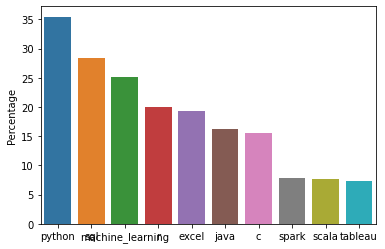

In [119]:
sns.barplot(x=percentages.index[:10], y=percentages[:10])

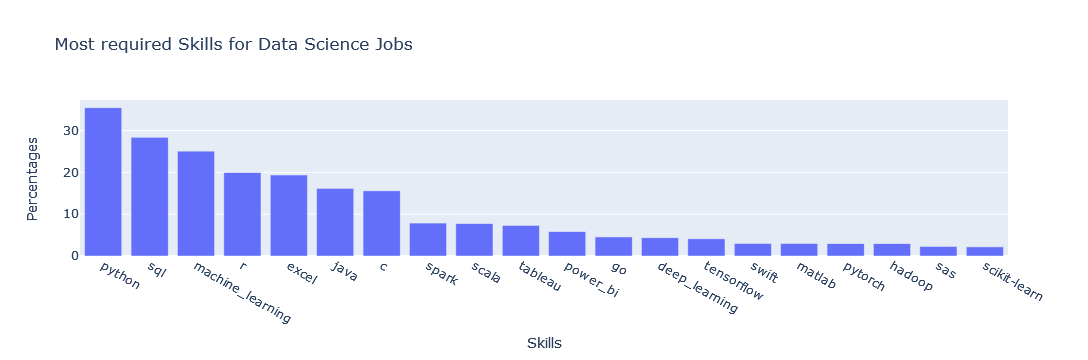

In [121]:
fig = px.bar(percentages[:20], title="Most required Skills for Data Science Jobs", labels={
                     "value": "Percentages", 
                    "index": "Skills"
                 })
fig.layout.update(showlegend=False)
fig